<a href="https://colab.research.google.com/github/cheungshirley/5001/blob/main/5001_Ind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description**
The dataset provides the average traffic speed per hour for a major road in Hong Kong from 2017 to 2018. Part of the dataset is provided as the training data, and your task is to predict the rest. 80% of the dataset is provided as the training data and 20% as the testing data, including the timestamp and the corresponding average speed. We sampled the testing data only from the year 2018 to provide you a training dataset that has the complete data spanning the year 2017. However, the speed information is sometimes missing due to device malfunction.

You have to submit the predicted results of these testing samples, which are then compared with the ground truth to evaluate the performance of your model.

In [138]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf

import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

x = pd.read_csv('train.csv', parse_dates=[1])
x_test = pd.read_csv('test.csv', parse_dates=[1])
x_submission = pd.read_csv('test.csv', parse_dates=[1])
print(x)
print(x_test)

          id                date      speed
0          0 2017-01-01 00:00:00  43.002930
1          1 2017-01-01 01:00:00  46.118696
2          2 2017-01-01 02:00:00  44.294158
3          3 2017-01-01 03:00:00  41.067468
4          4 2017-01-01 04:00:00  46.448653
...      ...                 ...        ...
14001  14001 2018-12-31 12:00:00  19.865269
14002  14002 2018-12-31 15:00:00  17.820375
14003  14003 2018-12-31 16:00:00  12.501851
14004  14004 2018-12-31 18:00:00  15.979319
14005  14005 2018-12-31 20:00:00  40.594183

[14006 rows x 3 columns]
        id                date
0        0 2018-01-01 02:00:00
1        1 2018-01-01 05:00:00
2        2 2018-01-01 07:00:00
3        3 2018-01-01 08:00:00
4        4 2018-01-01 10:00:00
...    ...                 ...
3499  3499 2018-12-31 17:00:00
3500  3500 2018-12-31 19:00:00
3501  3501 2018-12-31 21:00:00
3502  3502 2018-12-31 22:00:00
3503  3503 2018-12-31 23:00:00

[3504 rows x 2 columns]


Data Marshal

In [139]:
def extract_date(df,column):
  df[column+"_year2017"] = df[column].apply(lambda x:1 if x.year in [2017] else 0)
  df[column+"_year2018"] = df[column].apply(lambda x:1 if x.year in [2018] else 0)
  #df[column+"_year"] = df[column].apply(lambda x: x.year)
  #df[column+"_month"] = df[column].apply(lambda x: x.month)
  #df[column+"_day"] = df[column].apply(lambda x: x.day)
  df[column+"_month_verybegin"] = df[column].apply(lambda x:1 if x.day in [1,2,3,4,5,6] else 0)
  df[column+"_month_begin"] = df[column].apply(lambda x:1 if x.day in [7,8,9,10,11,12] else 0)
  df[column+"_month_middle"] = df[column].apply(lambda x:1 if x.day in [13,14,15,16,17,18] else 0)
  df[column+"_month_end"] = df[column].apply(lambda x:1 if x.day in [19,20, 21,22,23,24] else 0)
  df[column+"_month_veryend"] = df[column].apply(lambda x:1 if x.day in [25,26,27,28,29,30,31] else 0)
  df[column+"_month_1"] = df[column].apply(lambda x:1 if x.month == 1 else 0)
  df[column+"_month_2"] = df[column].apply(lambda x:1 if x.month == 2 else 0)
  df[column+"_month_3"] = df[column].apply(lambda x:1 if x.month == 3 else 0)
  df[column+"_month_4"] = df[column].apply(lambda x:1 if x.month == 4 else 0)
  df[column+"_month_5"] = df[column].apply(lambda x:1 if x.month == 5 else 0)
  df[column+"_month_6"] = df[column].apply(lambda x:1 if x.month == 6 else 0)
  df[column+"_month_7"] = df[column].apply(lambda x:1 if x.month == 7 else 0)
  df[column+"_month_8"] = df[column].apply(lambda x:1 if x.month == 8 else 0)
  df[column+"_month_9"] = df[column].apply(lambda x:1 if x.month == 9 else 0)
  df[column+"_month_10"] = df[column].apply(lambda x:1 if x.month == 10 else 0)
  df[column+"_month_11"] = df[column].apply(lambda x:1 if x.month == 11 else 0)
  df[column+"_month_12"] = df[column].apply(lambda x:1 if x.month == 12 else 0)
  df[column+"_Mon"] = df[column].apply(lambda x:1 if x.weekday() in [0] else 0)
  df[column+"_Tue"] = df[column].apply(lambda x:1 if x.weekday() in [1] else 0)
  df[column+"_Wed"] = df[column].apply(lambda x:1 if x.weekday() in [2] else 0)
  df[column+"_Thu"] = df[column].apply(lambda x:1 if x.weekday() in [3] else 0)
  df[column+"_Fri"] = df[column].apply(lambda x:1 if x.weekday() in [4] else 0)
  df[column+"_Sat"] = df[column].apply(lambda x:1 if x.weekday() in [5] else 0)
  df[column+"_Sun"] = df[column].apply(lambda x:1 if x.weekday() in [6] else 0)
  #df[column+"_rainfall_verylow"] = df[column].apply(lambda x:1 if x.month in [4,9] else 0)
  #df[column+"_rainfall_low"] = df[column].apply(lambda x:1 if x.month in [2,3,12] else 0)
  #df[column+"_rainfall_general"] = df[column].apply(lambda x:1 if x.month in [1,10,11] else 0)
  #df[column+"_rainfall_high"] = df[column].apply(lambda x:1 if x.month in [5,8] else 0)
  #df[column+"_rainfall_veryhigh"] = df[column].apply(lambda x:1 if x.month in [6,7] else 0)
  #df[column+"_quarter"] = df[column].apply(lambda x: x.quarter)
  #Check Weekend
  #df[column+"_isWeekend"] = df[column].apply(lambda x:1 if (x.weekday() in [5,6] or (x.weekday() in [4] and x.hour in [20,21,22,23]))else 0)
  #df[column+"_isWeekend"] = df[column].apply(lambda x:1 if x.weekday() in [5,6] else 0)
  #df[column+"_isWeekday"] = df[column].apply(lambda x:1 if (x.weekday() in [0,1,2,3,] or (x.weekday() in [4] and x.hour not in [20,21,22,23]))else 0)
  #Check HK Public Holiday
  df[column+"_isHoliday"] = df[column].apply(lambda x:1 if (x.date().strftime('%Y-%m-%d') in [
           '2017-01-02','2017-01-28','2017-01-30','2017-01-31','2017-04-04',
           '2017-04-14','2017-04-15','2017-04-17','2017-05-01','2017-05-03',
           '2017-05-30','2017-07-01','2017-10-02','2017-10-05','2017-10-28',
           '2017-12-25','2017-12-26',
           '2018-01-01','2018-02-16','2018-02-17','2018-02-19','2018-03-30',
           '2018-03-31','2018-04-02','2018-04-05','2018-05-01','2018-05-22',
           '2018-06-18','2018-07-02','2018-09-25','2018-10-01','2018-10-17',
           '2018-12-25','2018-12-26'
           ]) else 0)
  #http://v4.hkcoc.com/typhoon_record/
#  df[column+"_typhoon"] = df[column].apply(lambda x:1 if (x.date().strftime('%Y-%m-%d') in [
#           '2017-10-12','2017-10-13','2017-10-14','2017-10-15','2017-10-16',
#          '2017-08-31','2017-09-01','2017-09-02','2017-09-03','2017-09-04',
#           '2017-08-24','2017-08-25','2017-08-26','2017-08-27','2017-08-20',
#           '2017-08-21','2017-08-22','2017-08-23','2017-07-22','2017-07-23',
#           '2017-06-10','2017-06-11','2017-06-12','2017-06-13',
#           '2018-09-07','2018-09-08','2018-09-09','2018-09-10','2018-09-11',
#           '2018-09-12','2018-09-13','2018-09-14','2018-09-15','2018-09-16',
#           '2018-09-17','2018-10-22','2018-10-23','2018-10-24','2018-10-25',
#           '2018-10-26','2018-10-27','2018-10-28','2018-10-29','2018-10-30',
#           '2018-10-31','2018-11-01','2018-11-02','2018-08-09','2018-08-10',
#           '2018-08-11','2018-08-12','2018-08-13','2018-08-14','2018-08-15',
#           '2018-08-16','2018-08-17','2018-08-18','2018-07-15','2018-07-16',
#           '2018-07-15','2018-07-16','2018-07-17','2018-07-18','2018-07-19',
#           '2018-07-20','2018-07-21','2018-07-22','2018-07-23','2018-07-24',
#           '2018-07-25','2018-06-03','2018-06-04','2018-06-05','2018-06-06',
#           '2018-06-07','2018-06-08','2018-06-09'
#           ]) else 0)
  #df[column+"_hour"] = df[column].apply(lambda x: x.hour)
  df[column+"_early_morning"] = df[column].apply(lambda x:1 if x.hour in [0,1,2,3,4,5,6] else 0)
  df[column+"_general"] = df[column].apply(lambda x:1 if (x.hour in [10,11,12,13,14,15,16] and x.weekday() in [5,6]) or (x.hour in [7,8,9,10,11,12,13,14,15,16,17,18,19] and x.weekday() in [0, 1, 2, 3,4]) else 0)
  df[column+"_peak"] = df[column].apply(lambda x:1 if x.hour in [7,8,9,17,18,19] and x.weekday() in [0,1,2,3,4] else 0)
  df[column+"_mid_night"] = df[column].apply(lambda x:1 if x.hour in [20,21,22] else 0)

def set_nonpeak(df):
  if (df.item().date_on_peak==1 and df.date_isHoliday==1):
    df.date_on_peak = 0    

extract_date(x, 'date')
#set_nonpeak(x)
#x['date_on_peak'] = x['date_on_peak'].apply(lambda x:1 if x['date_on_peak'] == 1 else 0)
#monthcat=x.date_month.astype("category").cat.codes
#monthcat=pd.Series(monthcat)
#print(monthcat)
x.head()
#x.dtypes

,id,date,speed,date_year2017,date_year2018,date_month_verybegin,date_month_begin,date_month_middle,date_month_end,date_month_veryend,date_month_1,date_month_2,date_month_3,date_month_4,date_month_5,date_month_6,date_month_7,date_month_8,date_month_9,date_month_10,date_month_11,date_month_12,date_Mon,date_Tue,date_Wed,date_Thu,date_Fri,date_Sat,date_Sun,date_isHoliday,date_early_morning,date_general,date_peak,date_mid_night
0,0,2017-01-01 00:00:00,43.002930,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,1,2017-01-01 01:00:00,46.118696,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,2,2017-01-01 02:00:00,44.294158,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,3,2017-01-01 03:00:00,41.067468,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,4,2017-01-01 04:00:00,46.448653,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [140]:
x = x.drop('date', axis=1)

Print Chart

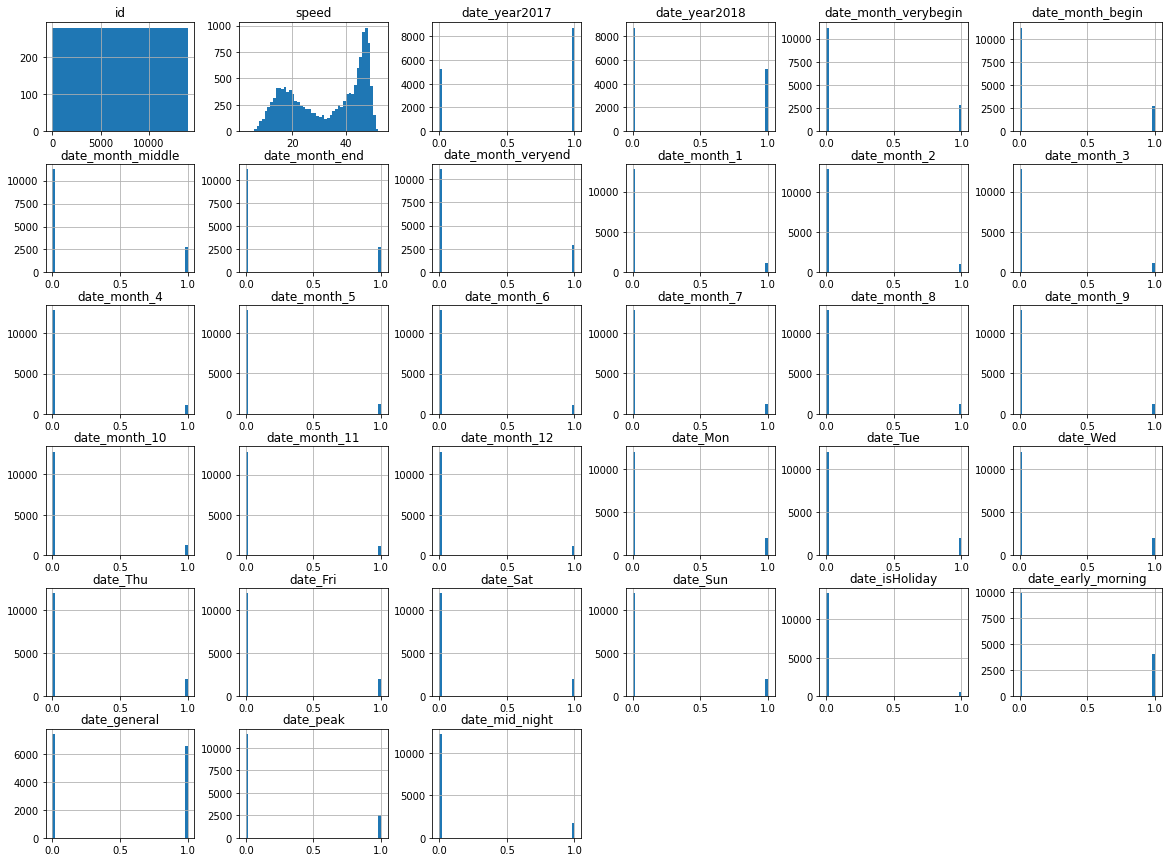

In [141]:
x.hist(bins=50,figsize=(20,15))
plt.show()

Matrix

In [142]:
#features = ['speed', 'date_isHoliday', 'date_isWeekend']
#from pandas.plotting import scatter_matrix
#scatter_matrix(x[features],figsize=(20,15))
#plt.show()

Variables Correlation

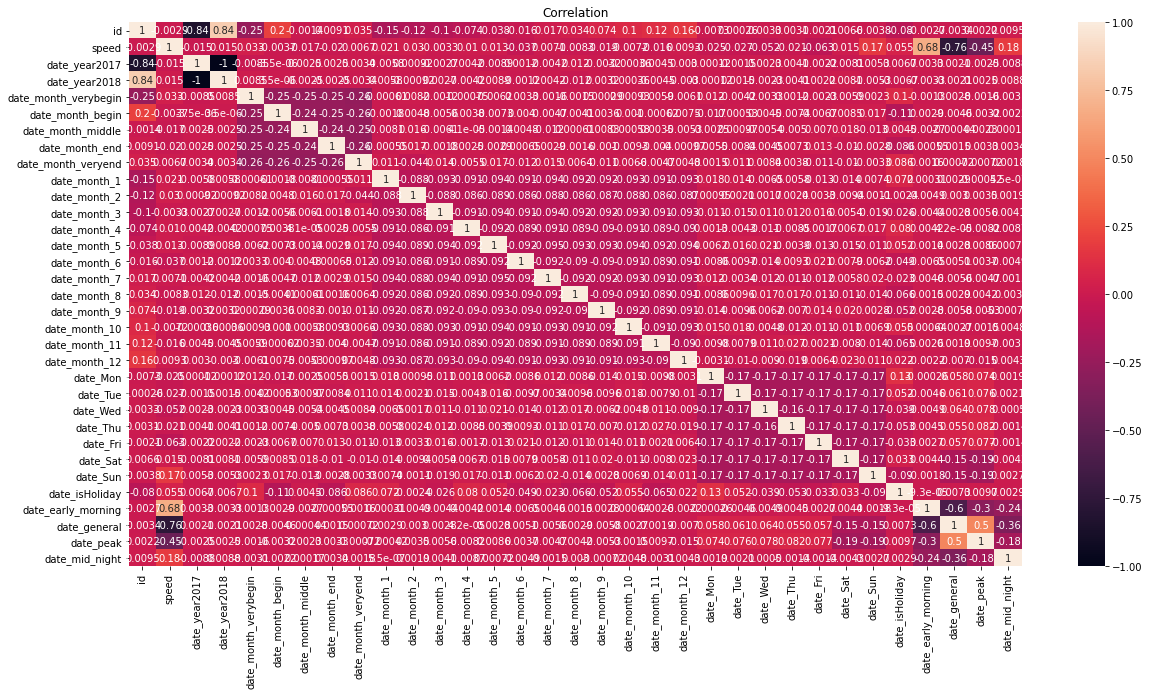

In [143]:
plt.figure(figsize = (20,10))

sns.heatmap(x.corr(), annot=True)
plt.title('Correlation')
plt.show()

Split data into two parts: training set(X_train, y_train) and test set(X_test, y_test).

In [144]:
y = x['speed']
x = x.drop('speed', axis=1)
x = x.drop('id', axis=1)
 
x.head()
y.head()

0    43.002930
1    46.118696
2    44.294158
3    41.067468
4    46.448653
Name: speed, dtype: float64

In [145]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 42)
#scaler = MinMaxScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_val = scaler.transform(X_val)
print(X_train)
print(y_train)

       date_year2017  date_year2018  ...  date_peak  date_mid_night
13848              0              1  ...          0               1
7110               1              0  ...          0               0
7471               1              0  ...          1               0
5768               1              0  ...          1               0
10484              0              1  ...          0               0
...              ...            ...  ...        ...             ...
5191               1              0  ...          1               0
13418              0              1  ...          0               0
5390               1              0  ...          0               0
860                1              0  ...          0               0
7270               1              0  ...          1               0

[11204 rows x 31 columns]
13848    40.459437
7110     13.905953
7471     12.939074
5768      9.186619
10484    43.419208
           ...    
5191     24.637279
13418    35.306286
5390 

Method 1 - https://cloudxlab.com/blog/regression-using-tensorflow-keras-api/

In [146]:
# Import the kera modules
from keras.layers import Input
from keras.models import Model
from keras.callbacks import EarlyStopping
# This returns a tensor. Since the input only has one column
inputs = Input(shape=(31,))

# a layer instance is callable on a tensor, and returns a tensor
# To the first layer we are feeding inputs
x = Dense(68, activation='relu')(inputs)
# To the next layer we are feeding the result of previous call here it is h
x = Dense(136, activation='relu')(x)
x = Dense(136, activation='relu')(x)

# Predictions are the result of the neural network. Notice that the predictions are also having one column.
predictions = Dense(1)(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
# Here the loss function is mse - Mean Squared Error because it is a regression problem.
model.compile(optimizer='rmsprop',loss='mse',metrics=['mse'])

In [147]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=50, mode='min')

history = model.fit(X_train, y_train,  epochs=5000, batch_size=11204, validation_data=(X_val, y_val), callbacks=[early_stopping_monitor])  # starts training

Streaming output truncated to the last 5000 lines.
Epoch 1194/5000
1/1 [==============================] - 0s 28ms/step - loss: 34.5243 - mse: 34.5243 - val_loss: 39.2148 - val_mse: 39.2148
Epoch 1195/5000
1/1 [==============================] - 0s 33ms/step - loss: 34.6846 - mse: 34.6846 - val_loss: 39.0613 - val_mse: 39.0613
Epoch 1196/5000
1/1 [==============================] - 0s 28ms/step - loss: 34.4968 - mse: 34.4968 - val_loss: 39.1800 - val_mse: 39.1800
Epoch 1197/5000
1/1 [==============================] - 0s 28ms/step - loss: 34.6442 - mse: 34.6442 - val_loss: 39.0262 - val_mse: 39.0262
Epoch 1198/5000
1/1 [==============================] - 0s 38ms/step - loss: 34.4570 - mse: 34.4570 - val_loss: 39.1474 - val_mse: 39.1474
Epoch 1199/5000
1/1 [==============================] - 0s 29ms/step - loss: 34.6062 - mse: 34.6062 - val_loss: 39.0125 - val_mse: 39.0125
Epoch 1200/5000
1/1 [==============================] - 0s 35ms/step - loss: 34.4376 - mse: 34.4376 - val_loss: 39.1464 - 

Marshal Test Data

In [148]:
extract_date(x_test, 'date')
x_test = x_test.drop('date', axis=1)
x_test = x_test.drop('id', axis=1)
x_test.head()

,date_year2017,date_year2018,date_month_verybegin,date_month_begin,date_month_middle,date_month_end,date_month_veryend,date_month_1,date_month_2,date_month_3,date_month_4,date_month_5,date_month_6,date_month_7,date_month_8,date_month_9,date_month_10,date_month_11,date_month_12,date_Mon,date_Tue,date_Wed,date_Thu,date_Fri,date_Sat,date_Sun,date_isHoliday,date_early_morning,date_general,date_peak,date_mid_night
0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
2,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
3,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
4,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0


Prediction

In [149]:
y_test = np.float64(model.predict(x_test))
print(y_test)
print(y_test.dtype)

y_test = y_test.flatten()
print(y_test) 

[[49.63079453]
 [49.63079453]
 [34.98942947]
 ...
 [43.0510025 ]
 [43.0510025 ]
 [45.11898804]]
float64
[49.63079453 49.63079453 34.98942947 ... 43.0510025  43.0510025
 45.11898804]


Output the Data

In [150]:
pred=pd.DataFrame({'speed':list(y_test)},columns=['speed'])
submission=pd.concat([x_submission.drop('date',axis=1),pred],axis=1)
submission.head()

,id,speed
0,0,49.630795
1,1,49.630795
2,2,34.989429
3,3,34.989429
4,4,35.656113


In [151]:
from subprocess import check_output
#print(check_output(["ls","..\"]).decode("utf8"))
submission.to_csv('test_20660026.csv',index=False)